# Cell size computation

Approaches for cell size computation

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import scanpy as sc
import scipy.sparse as sparse
import pickle as pkl
from scipy.optimize import root, minimize, root_scalar, diagbroyden, least_squares, approx_fprime
import scipy.optimize as opt

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'
data_path = '/data_volume/parameter_estimation/'

### Read IFN data

In [3]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[(adata.obs.cell == 'CD14+ Monocytes')].copy()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Use least variable genes

In [4]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.1-py3.7.egg')
import memento

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.1-py3.7.egg/memento/simulate.py:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [5]:
adata_ct = adata.copy()

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=0.3)

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=False, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)

In [135]:
total_library_count = adata_ct.uns['memento']['all_total_size_factor']/adata_ct.uns['memento']['all_total_size_factor'].mean()

In [167]:
lv_sf = adata_ct.uns['memento']['all_size_factor']

In [136]:
len(adata_ct.uns['memento']['least_variable_genes'])

559

### Implement pooled TMM

In [137]:
def trimmed_mean(a, b):
    
    ratio = a / b
    
#     return np.median(ratio)
    llim, ulim = np.quantile(ratio, [0.3, 0.7])
#     return np.median(ratio)
    return ratio[(ratio > llim) & (ratio < ulim)].mean()
    

In [138]:
means = adata.X.mean(axis=0).A1

In [139]:
# Gene selection
expr_matrix = adata[:, adata_ct.uns['memento']['least_variable_genes']].X.copy()
library_count = expr_matrix.sum(axis=1).A1
library_count /= library_count.mean()

In [140]:
# library count normalization
expr_matrix = sparse.diags(1/library_count)@expr_matrix

# Mean pseudocell
mean_cell = expr_matrix.mean(axis=0).A1

In [141]:
%%time

pool_factors_list = []
toeplitz_list = []
n_cells = expr_matrix.shape[0]

for window_size in range(100, 200, 20):
    
    pool_factors = np.zeros(n_cells)

    # ith pool includes cell indices i to i+window_size-1
    pool_sum = expr_matrix[:window_size, :].sum(axis=0).A1
    pool_factors[0] = trimmed_mean(pool_sum, mean_cell)
    for pool in range(n_cells-1):

        i = pool # index to subtract
        j = (pool + window_size) % n_cells # index to add 

        pool_sum[expr_matrix.indices[expr_matrix.indptr[i]:expr_matrix.indptr[i+1]]] -= \
            expr_matrix.data[expr_matrix.indptr[i]:expr_matrix.indptr[i+1]]
        pool_sum[expr_matrix.indices[expr_matrix.indptr[j]:expr_matrix.indptr[j+1]]] += \
            expr_matrix.data[expr_matrix.indptr[j]:expr_matrix.indptr[j+1]]

        pool_factors[pool + 1] = trimmed_mean(pool_sum, mean_cell)
    
    toeplitz = \
        sparse.diags(diagonals=np.ones(window_size), offsets=np.arange(window_size), shape=(n_cells, n_cells)) + \
        sparse.diags(diagonals=np.ones(window_size), offsets=np.arange(window_size)-n_cells, shape=(n_cells, n_cells))
    
    pool_factors_list.append(pool_factors)
    toeplitz_list.append(toeplitz)


CPU times: user 3.88 s, sys: 1.78 ms, total: 3.88 s
Wall time: 3.88 s


In [142]:
pool_factors = np.concatenate(pool_factors_list)
del pool_factors_list
toeplitz = sparse.vstack(toeplitz_list)
del toeplitz_list

In [143]:
toeplitz.shape

(26705, 5341)

In [144]:
%%time
# res_1 = sparse.linalg.lsqr(toeplitz, pool_factors)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


In [145]:
%%time
res_2 = sparse.linalg.lsmr(toeplitz, pool_factors, atol=1e-9, btol=1e-9, damp=0)

CPU times: user 7min 19s, sys: 13min 8s, total: 20min 27s
Wall time: 1min 16s


In [162]:
tmm_sf = res_2[0]*library_count
# size_factor = fitted.coef_*library_count

<AxesSubplot:>

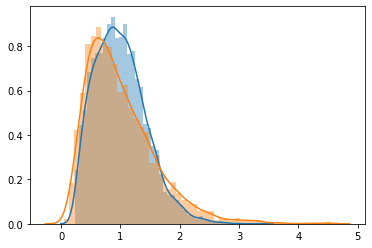

In [163]:
sns.distplot(total_library_count)
sns.distplot(tmm_sf)


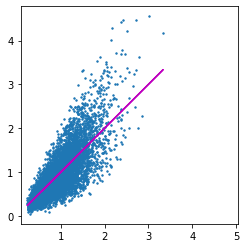

In [148]:
plt.scatter(total_library_count, size_factor, s=2);
plt.plot(total_library_count, total_library_count, c='m')
plt.axis('square');

### Mean of least variable M values

In [154]:
expr_matrix = adata[:, adata_ct.uns['memento']['least_variable_genes']].X.copy()
expr_matrix = sparse.diags(1/adata.X.sum(axis=1).A1)@expr_matrix


In [165]:
mlvm_sf = expr_matrix.mean(axis=1).A1
mlvm_sf /= mlvm_sf.mean()
mlvm_sf *= total_library_count


### compute using least variable genes

In [174]:
 adata[adata.obs.stim == 'stim', 'IRF1'].X.todense()

matrix([[1.],
        [0.],
        [0.],
        ...,
        [1.],
        [0.],
        [0.]], dtype=float32)

8.576638


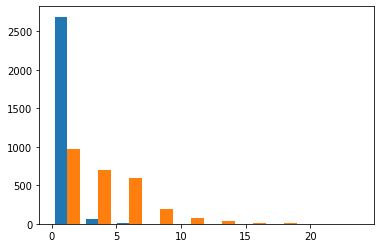

In [184]:
x = adata[adata.obs.stim == 'ctrl', 'IRF7'].X.todense().A1
y = adata[adata.obs.stim == 'stim', 'IRF7'].X.todense().A1
plt.hist([x,y])

print(y.mean()/x.mean())

1.1807262


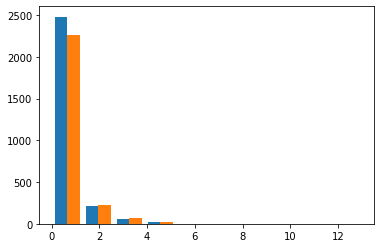

In [197]:
x = adata[adata.obs.stim == 'ctrl', 'NFE2L2'].X.todense().A1
y = adata[adata.obs.stim == 'stim', 'NFE2L2'].X.todense().A1
plt.hist([x,y])

print(y.mean()/x.mean())

6.521254


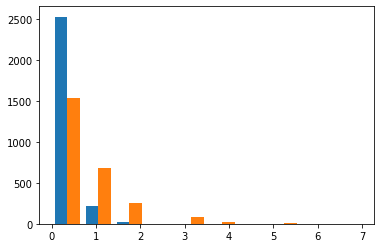

In [181]:
x = adata[adata.obs.stim == 'ctrl', 'IRF2'].X.todense().A1
y = adata[adata.obs.stim == 'stim', 'IRF2'].X.todense().A1
plt.hist([x,y])

print(y.mean()/x.mean())

In [118]:
tmm_size_factor = size_factor.copy()

In [119]:
stats.pearsonr(adata_ct.uns['memento']['all_size_factor'], total_library_count)

(0.7549722039461234, 0.0)

In [120]:
stats.pearsonr(total_library_count, tmm_size_factor)

(0.47033733312042725, 3.1727352660028723e-292)

(0.8450933259771117, 0.0)


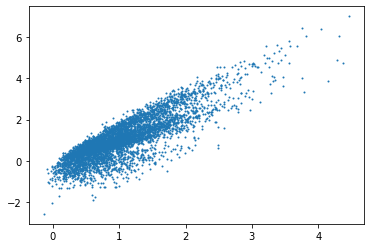

In [121]:
print(stats.pearsonr(adata_ct.uns['memento']['all_size_factor'], tmm_size_factor))
plt.scatter(adata_ct.uns['memento']['all_size_factor'], tmm_size_factor, s=1)
# plt.plot(tmm_size_factor, tmm_size_factor, c='m')

### See the downstream effects - updated RV code

In [6]:
import itertools

In [7]:
def compute_ind_mean(adata_ct):
    
    ctrl_mean_corr = 0
    stim_mean_corr = 0

    ctrl_count = 0
    stim_count = 0

    for group in adata_ct.uns['memento']['groups']:

        temp = adata_ct.uns['memento']['2d_moments'][group]['corr'].copy()
        temp[(temp > 1) | (temp < -1)] = np.nan
        temp[np.isnan(temp)] = 0
        
        num_cells = adata_ct.uns['memento']['group_cells'][group].shape[0]

        if 'ctrl' in group:
            ctrl_mean_corr += temp * num_cells
            ctrl_count += ~np.isnan(temp) * num_cells

        if 'stim' in group:
            stim_mean_corr += temp * num_cells
            stim_count += ~np.isnan(temp) * num_cells

    ctrl_mean_corr /= ctrl_count
    stim_mean_corr /= stim_count

    del ctrl_count, stim_count
    
    return ctrl_mean_corr, stim_mean_corr

def nancorr(a,b):
    cond = np.isfinite(a) & np.isfinite(b)
    return stats.pearsonr(a[cond], b[cond])

def nandistplot(a):
    sns.distplot(a[np.isfinite(a)])

(0.015888274822828927, 0.4776136935175312)


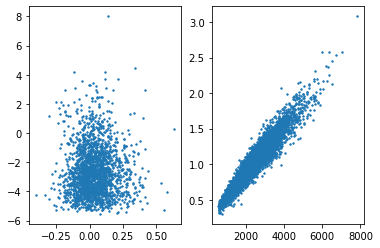

In [8]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=.05)
# adata_ct.uns['memento']['all_size_factor'] = tmm_size_factor

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()

genes = adata_ct.var.index.tolist()
# print(set(tfs) & set(genes))
gene_1 =np.random.choice(genes, 2000, replace=True)
gene_2 = np.random.choice(genes, 2000, replace=True)
gene_pairs = list(zip(gene_1, gene_2))

mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
    adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
print(nancorr(mean_prod, corr))

plt.subplot(1, 2, 1)
plt.scatter(corr, mean_prod, s=2)
plt.subplot(1, 2, 2)
plt.scatter(adata_ct.uns['memento']['all_total_size_factor'], adata_ct.uns['memento']['all_size_factor'], s=2)


In [9]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=0.05)
# adata_ct.uns['memento']['all_size_factor'] = tmm_size_factor

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=False, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
# isgf3_genes = list(set(isgf3_genes) & set(genes))

genes = adata_ct.var.index.tolist()
gene_1 = ['STAT1']
gene_2 = ['IFIT1', 'ISG15', 'OAS1', 'OASL', 'MX1', 'IFITM1', 'ISG20', 'IFITM3', 'SAT1']
gene_2 = list(set(gene_2) & set(genes))
gene_pairs = list(itertools.product(gene_1, gene_2))

mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
    adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

# corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
# plt.scatter(mean_prod, corr, s=2)

# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^ctrl']['corr'])
# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^stim']['corr'])

ctrl, stim = compute_ind_mean(adata_ct)
print(gene_2)
print(ctrl)
print(stim)

['OASL', 'OAS1', 'ISG20', 'ISG15', 'IFITM1', 'IFIT1', 'MX1', 'IFITM3', 'SAT1']
[0.08295282 0.13856375 0.07930507 0.03691753 0.09439573 0.07735945
 0.14681004 0.10356905 0.07074912]
[-0.04576159  0.24978866 -0.04417856  0.08966631 -0.14276499  0.25447154
  0.26590306 -0.05651703  0.020454  ]


/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


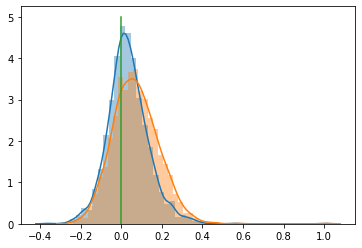

In [67]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=.05, shrinkage=0.5)
# adata_ct.uns['memento']['all_size_factor'] = tmm_size_factor

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
# isgf3_genes = list(set(isgf3_genes) & set(genes))

g = 'IRF2'
gene_1 = [g for i in range(len(genes))]
gene_2 = genes
gene_pairs = list(zip(gene_1, gene_2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
# mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

ctrl, stim = compute_ind_mean(adata_ct)
nandistplot(ctrl)
nandistplot(stim)
plt.plot([0, 0], [0, 5])

In [68]:
stim.abs().mean() - ctrl.abs().mean()

0.024471369555902664

In [62]:
stim.mean() - ctrl.mean()

0.03720779288793161

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


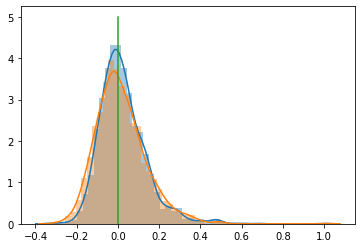

In [27]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=.05)
# adata_ct.uns['memento']['all_size_factor'] = tmm_size_factor

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()
# isgf3_genes = list(set(isgf3_genes) & set(genes))

g = 'ISG20'
gene_1 = [g for i in range(len(genes))]
gene_2 = genes
gene_pairs = list(zip(gene_1, gene_2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
# mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

ctrl, stim = compute_ind_mean(adata_ct)
nandistplot(ctrl)
nandistplot(stim)
plt.plot([0, 0], [0, 5])

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.1-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


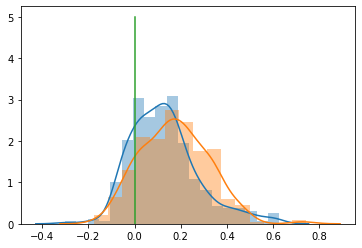

In [129]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])

memento.create_groups(adata_ct, label_columns=['ind','stim'], inplace=True, q=0.07)

memento.compute_size_factors(adata_ct, trim_percent=0.1)
# adata_ct.uns['memento']['all_size_factor'] = tmm_size_factor

memento.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    filter_mean_thresh=0.07, 
    min_perc_group=0.8)
genes = adata_ct.var.index.tolist()

# print(set(tfs) & set(genes))
gene_1 =list(set(ifn_genes) & set(genes))
gene_2 = list(set(ifn_genes) & set(genes))
gene_pairs = list(itertools.combinations(gene_1, 2))

# mean_prod = adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_1)] *\
#     adata_ct.uns['memento']['1d_moments']['sg^stim'][0][memento.util._get_gene_idx(adata_ct, gene_2)]
mean_prod = np.log(mean_prod)

memento.compute_2d_moments(
    adata_ct, 
    gene_pairs=gene_pairs)

# corr = adata_ct.uns['memento']['2d_moments']['sg^stim']['corr']
# plt.scatter(mean_prod, corr, s=2)

# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^ctrl']['corr'])
# nandistplot(adata_ct.uns['memento']['2d_moments']['sg^stim']['corr'])

ctrl, stim = compute_ind_mean(adata_ct)
nandistplot(ctrl)
nandistplot(stim)
plt.plot([0, 0], [0, 5])

In [68]:
ifn_genes = """ABCE1
ADAR
BST2
EGR1
GBP2
HLA-A
HLA-B
HLA-C
HLA-E
HLA-F
HLA-G
HLA-H
IFI27
IFI35
IFI6
IFIT1
IFIT2
IFIT3
IFITM1
IFITM2
IFITM3
IFNA1
IFNA10
IFNA13
IFNA14
IFNA16
IFNA17
IFNA2
IFNA21
IFNA4
IFNA5
IFNA6
IFNA7
IFNA8
IFNAR1
IFNAR2
IFNB1
IP6K2
IRF1
IRF2
IRF3
IRF4
IRF5
IRF6
IRF7
IRF8
IRF9
ISG15
ISG20
JAK1
MX1
MX2
OAS1
OAS2
OAS3
OASL
PSMB8
PTPN1
PTPN11
PTPN6
RNASEL
RSAD2
SAMHD1
SOCS1
SOCS3
STAT1
STAT2
TYK2
USP18
XAF1""".split()